In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\aljos\miniconda3\envs\drlnd\lib\site-packages\gym\core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg import DDPGAgent

In [3]:
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
state_size = env.brains[env.brain_names[0]].vector_observation_space_size
action_size = env.brains[env.brain_names[0]].vector_action_space_size

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [7]:
agent = DDPGAgent(state_dim=state_size, action_dim=action_size, num_agents=num_agents, seed=2)

In [8]:
## Training the agent

def model(n_eps: int = 1000):
    """Training the agent
    
    Params
    ======
        n_eps (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode

    Returns
    =======
        scores (list): list of scores
    """
    scores = []
    scores_window = deque(maxlen=100)

    for i_episode in range(1, n_eps+1):
        
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        score = np.zeros(num_agents)
        episode_running = True

        while episode_running:
            action = agent.act(state)
            action = np.clip(action, -1, 1)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += env_info.rewards

            if np.any(done):
                episode_running = False

        scores_window.append(np.mean(score))
        scores.append(np.mean(score))

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

In [9]:
scores = model()

Episode 100	Average Score: 28.45
Episode 105	Average Score: 30.17
Environment solved in 105 episodes!	Average Score: 30.17


In [16]:
running_mean_without_window = []
for i in range(len(scores)):
    running_mean_without_window.append(np.mean(scores[max(0, i-100):(i+1)]))

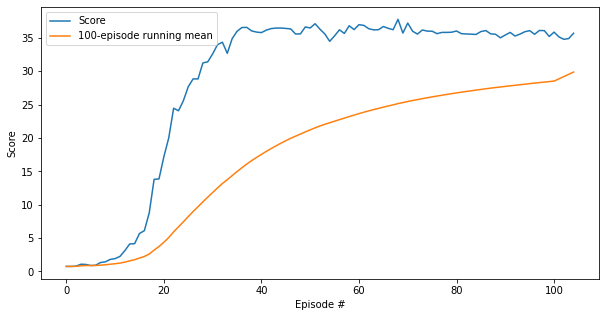

In [18]:
## plot the scores and the running mean
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(scores)), running_mean_without_window, label='100-episode running mean')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

In [19]:
## Close the environment
env.close()